In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm   # for progress bar
from utils import (
    save_checkpoint,
    load_checkpoint,
    get_loaders,
    check_accuracy,
    save_predictions_as_imgs
    )
from model import UNET

In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Brain Tumor Segmentation.zip"
extract_path = "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Brain Tumor Segmentation Extracted"

# Extract ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List extracted files
os.listdir(extract_path)

['Brain Tumor Segmentation']

In [ ]:
IMG_DIR      =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Brain Tumor Segmentation Extracted/Brain Tumor Segmentation/images"
MASK_DIR     =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Brain Tumor Segmentation Extracted/Brain Tumor Segmentation/masks"
VAL_IMG_DIR  =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Brain Tumor Segmentation Extracted/Brain Tumor Segmentation/val_images"
VAL_MASK_DIR =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Brain Tumor Segmentation Extracted/Brain Tumor Segmentation/val_masks"

In [ ]:
Device = "cuda" if torch.cuda.is_available() else "cpu"
Learning_rate = 1e-3 # 1e-4 originally
Batch_size  = 32
num_epochs  = 5
num_workers = 4
IMAGE_HEIGHT = 256 # 512 originally
IMAGE_WIDTH  = 256 # 512 originally
PIN_MEMORY = True
LOAD_MODEL = False
CHECKPOINT_NAME = None


In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=Device)
        # targets must be float for BCELoss (Binary Cross Entropy Loss)
        targets = targets.float().unsqueeze(1).to(device=Device)

        # forward
        with torch.amp.autocast(device_type=Device):
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [ ]:
def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    model = UNET(in_channel=1, out_channel=1).to(Device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=Learning_rate)
    train_loader, val_loader = get_loaders(
        IMG_DIR,
        MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        Batch_size,
        train_transform,
        val_transform,
        num_workers,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        # load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)
        load_checkpoint(model=model, optimizer=optimizer, checkpoint_name=CHECKPOINT_NAME)
        check_accuracy(val_loader, model, device=Device)

    scaler = torch.amp.GradScaler()

    for epoch in range(num_epochs):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":  optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

        # check accuracy
        check_accuracy(val_loader, model, device=Device)

        # print some examples to a folder
        if epoch != num_epochs - 1:
            save_predictions_as_imgs(
                val_loader, model, folder="saved_images/", device=Device, show_last_epoch=False
            )
        else:
            save_predictions_as_imgs(
                val_loader, model, folder="saved_images/", device=Device, show_last_epoch=True
            )

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 96/96 [01:38<00:00,  1.03s/it, loss=0.116]


✅ Checkpoint saved: checkpoint_1_2025-03-26_05-37-09.pth.tar
Got 2777549/2818048 with acc 98.56
Dice score: 0.0


100%|██████████| 96/96 [01:17<00:00,  1.24it/s, loss=0.0725]


✅ Checkpoint saved: checkpoint_2_2025-03-26_05-38-31.pth.tar
Got 2780536/2818048 with acc 98.67
Dice score: 0.3895208537578583


100%|██████████| 96/96 [01:16<00:00,  1.25it/s, loss=0.0381]


✅ Checkpoint saved: checkpoint_3_2025-03-26_05-39-53.pth.tar
Got 2797807/2818048 with acc 99.28
Dice score: 0.687406599521637


100%|██████████| 96/96 [01:16<00:00,  1.25it/s, loss=0.0497]


✅ Checkpoint saved: checkpoint_4_2025-03-26_05-41-14.pth.tar
Got 2795132/2818048 with acc 99.19
Dice score: 0.7099449634552002


100%|██████████| 96/96 [01:16<00:00,  1.25it/s, loss=0.0424]


✅ Checkpoint saved: checkpoint_5_2025-03-26_05-42-36.pth.tar
Got 2797777/2818048 with acc 99.28
Dice score: 0.7354550361633301


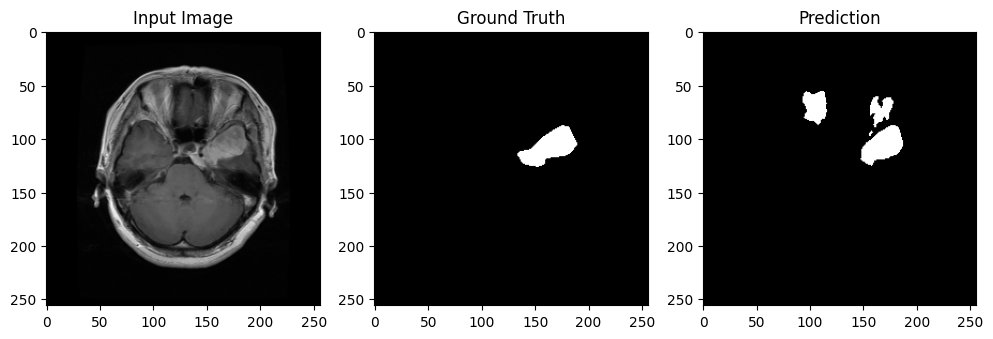

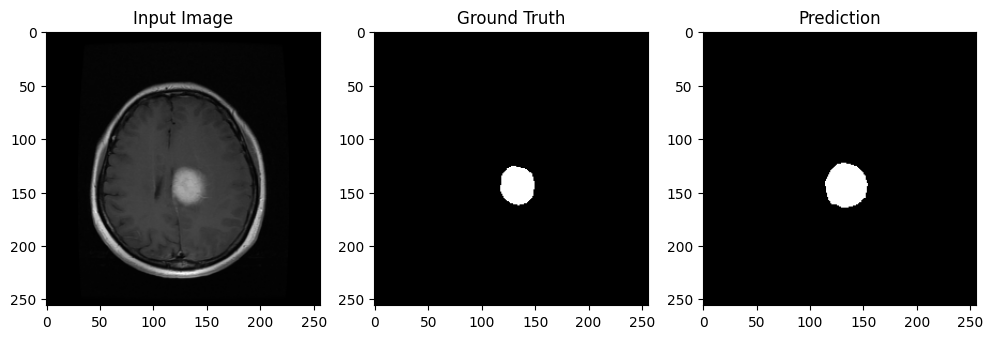

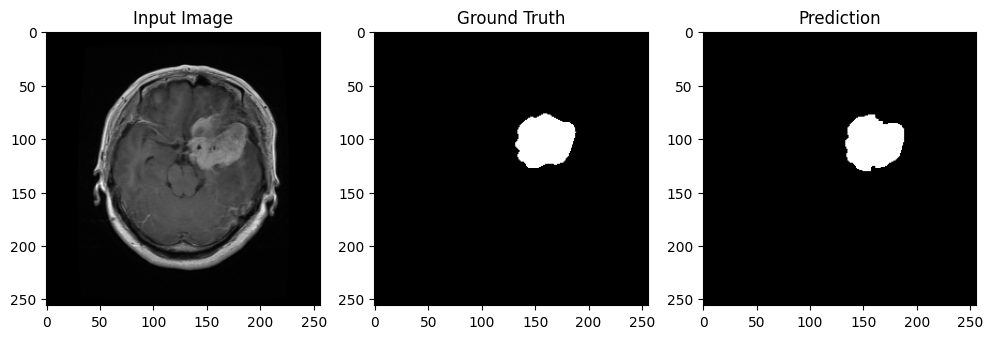

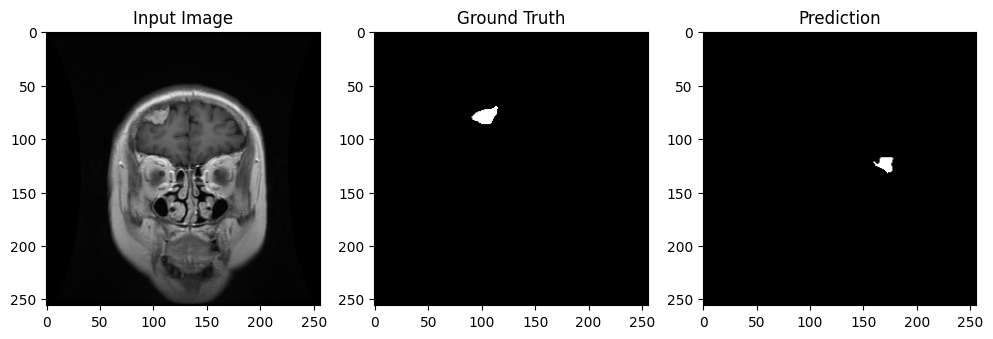

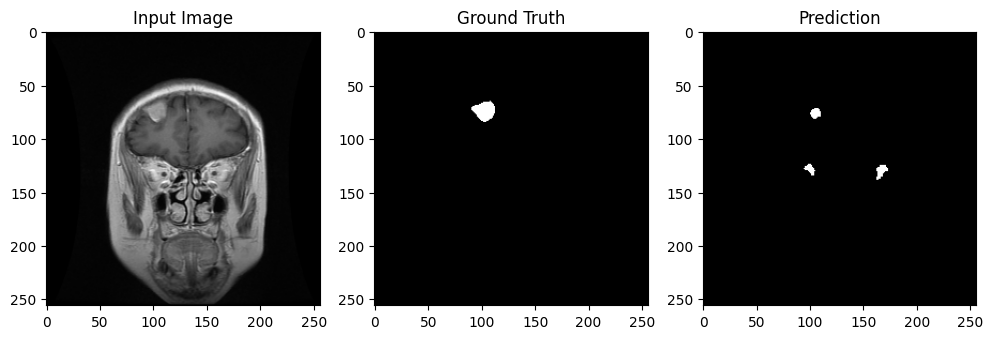

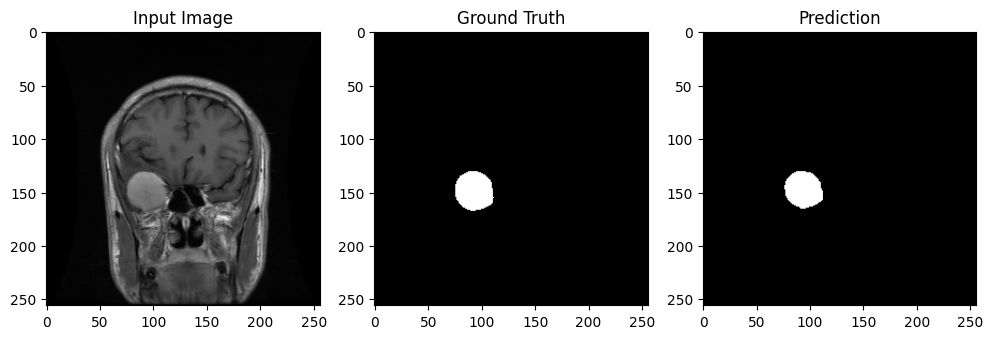

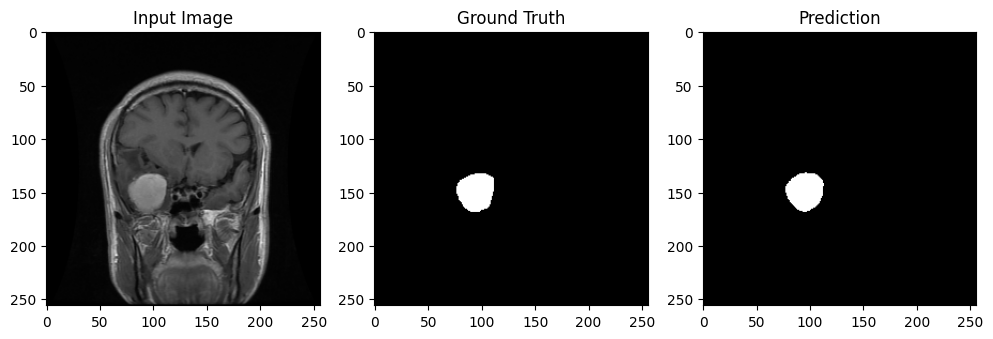

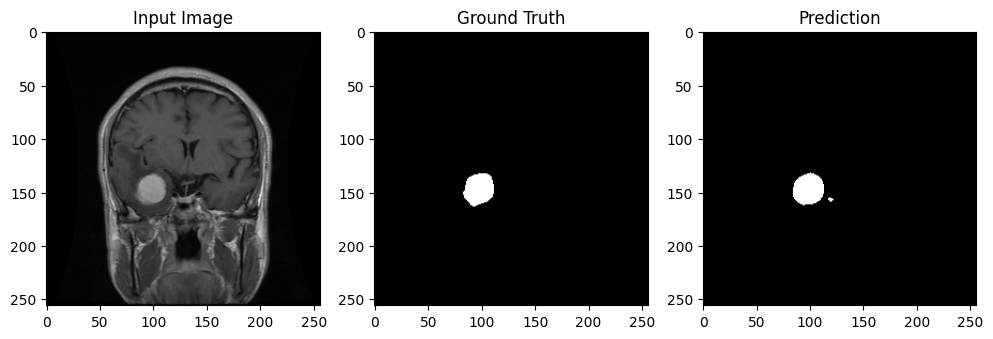

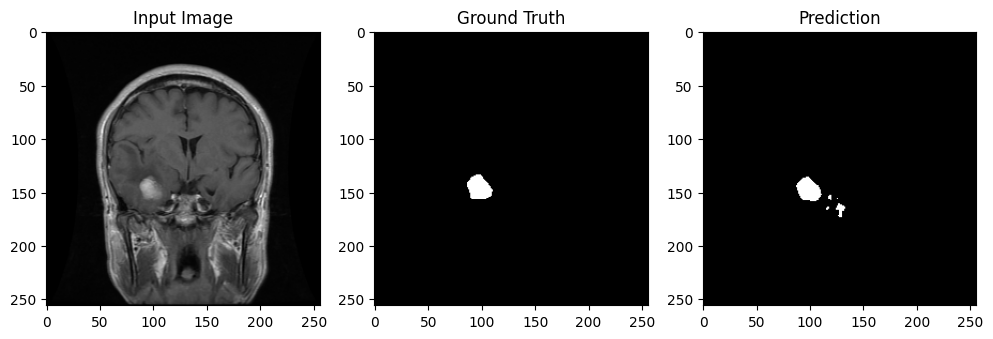

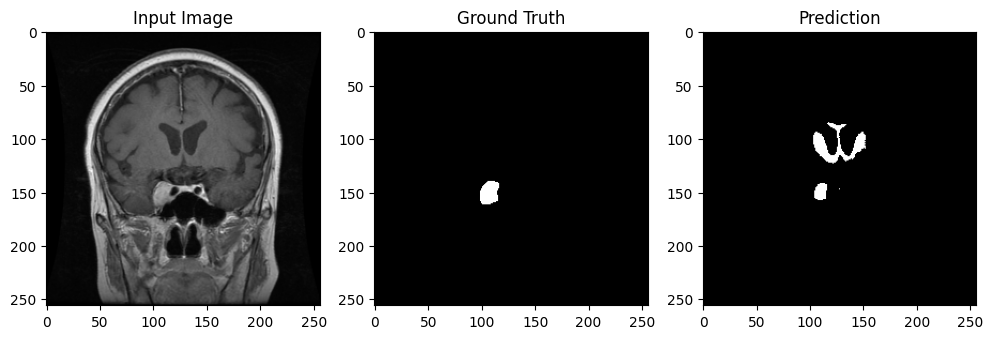

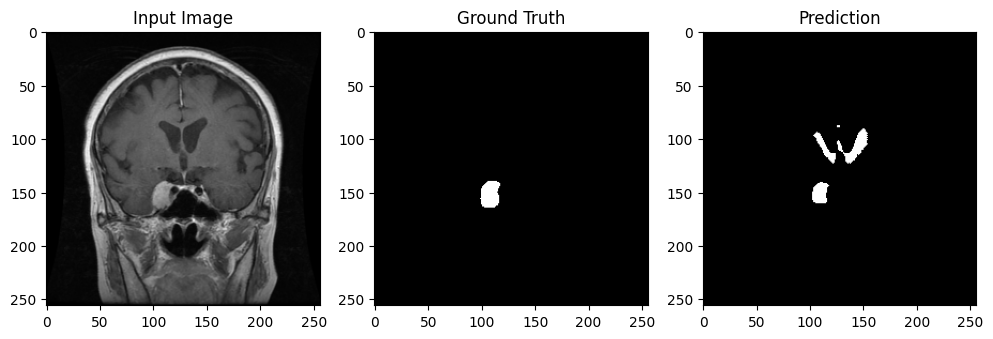

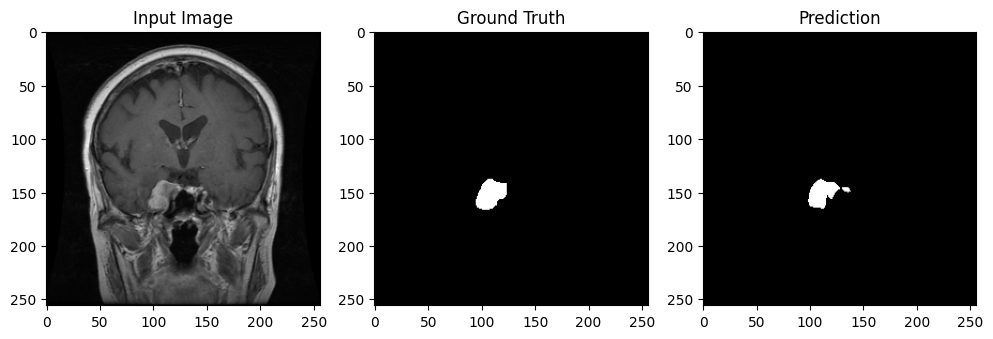

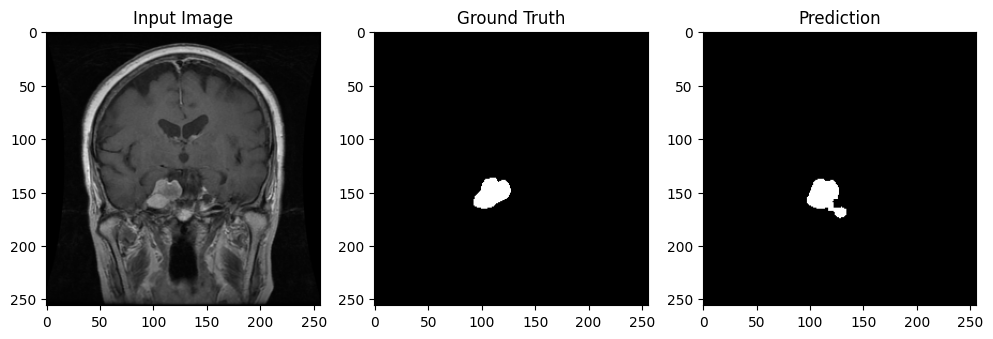

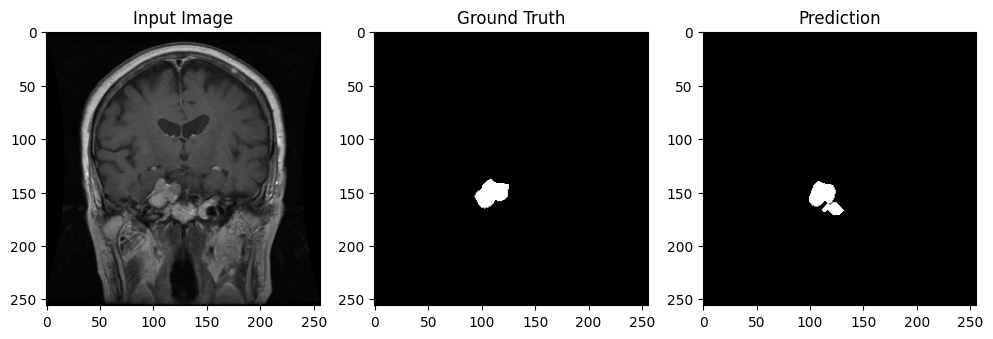

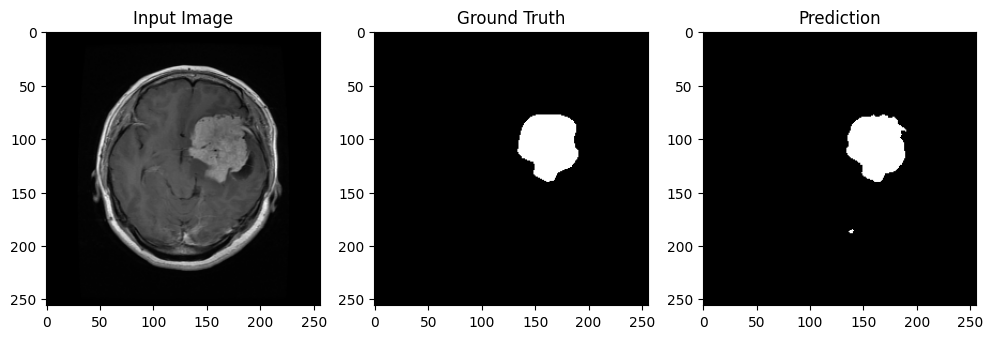

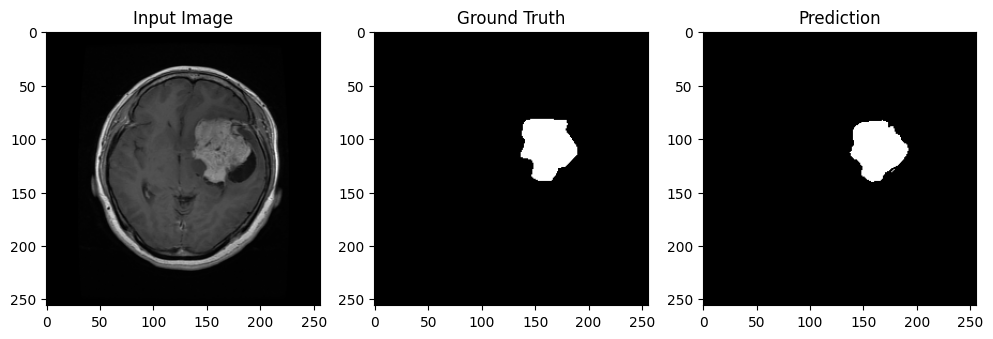

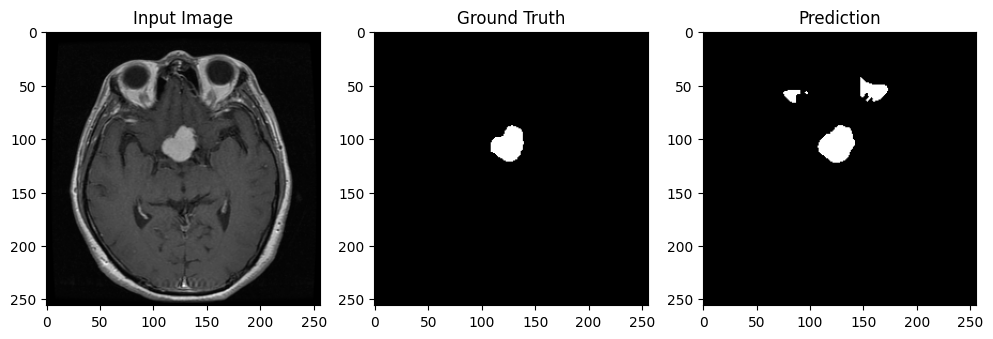

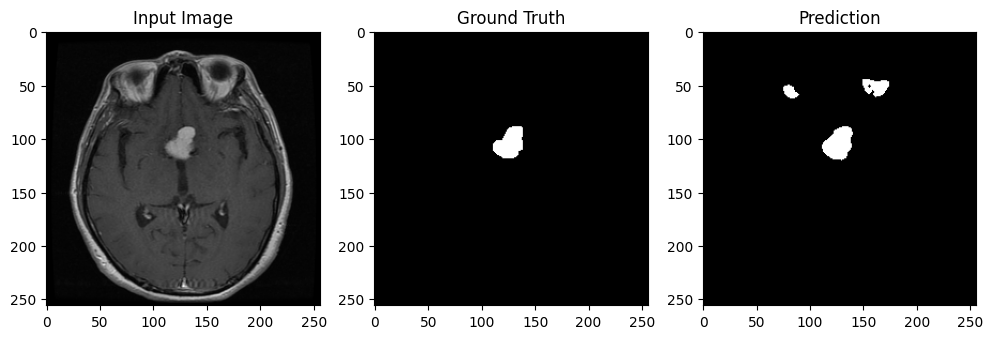

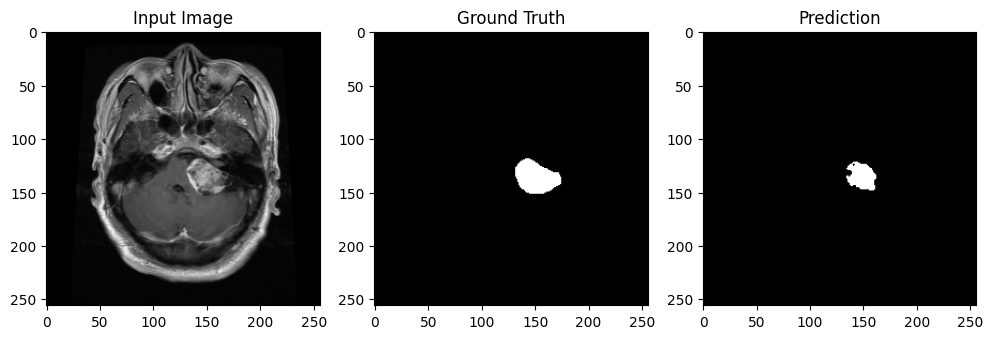

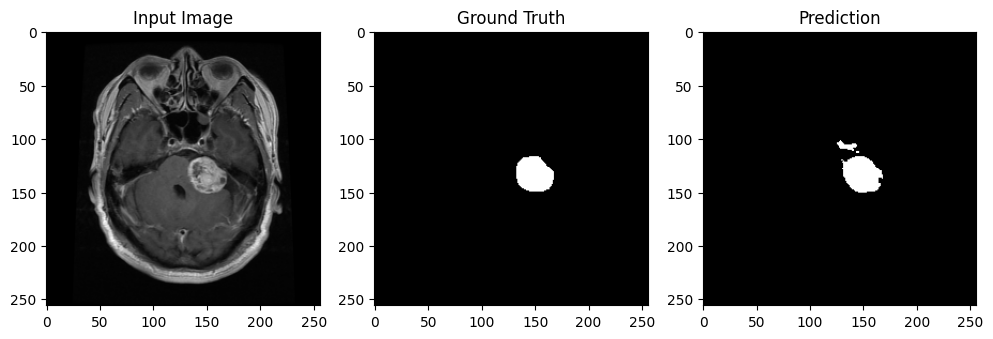

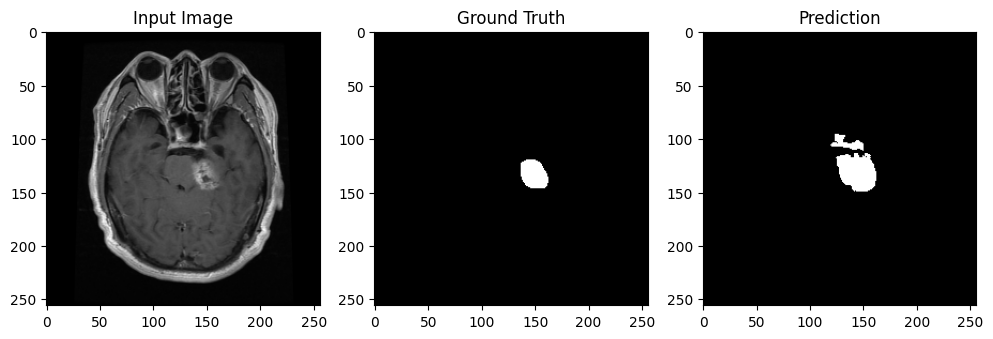

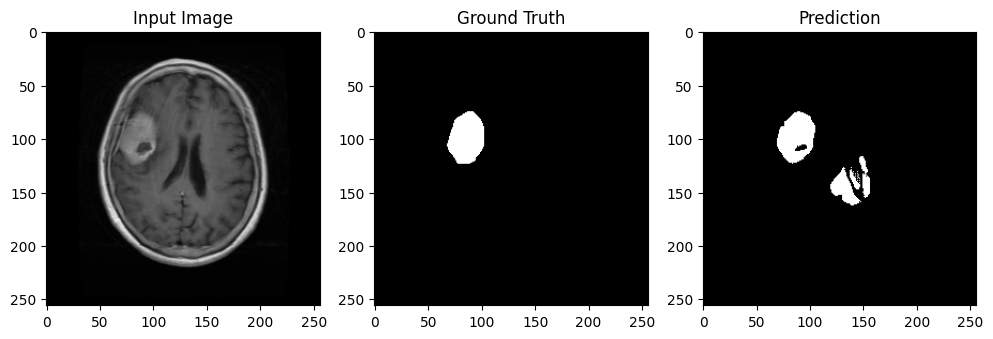

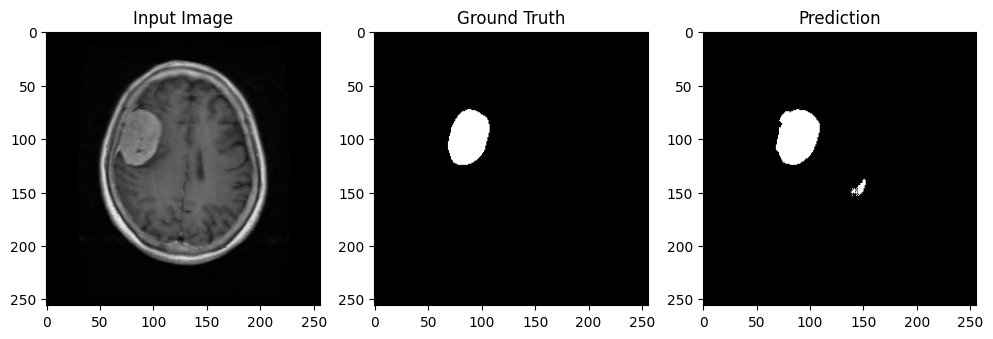

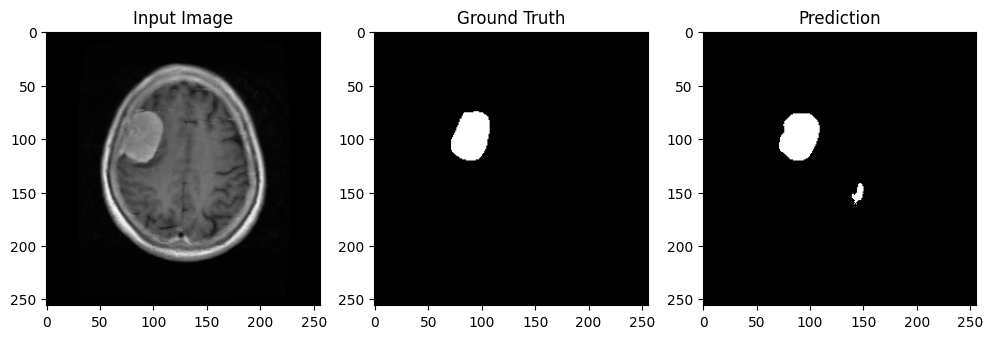

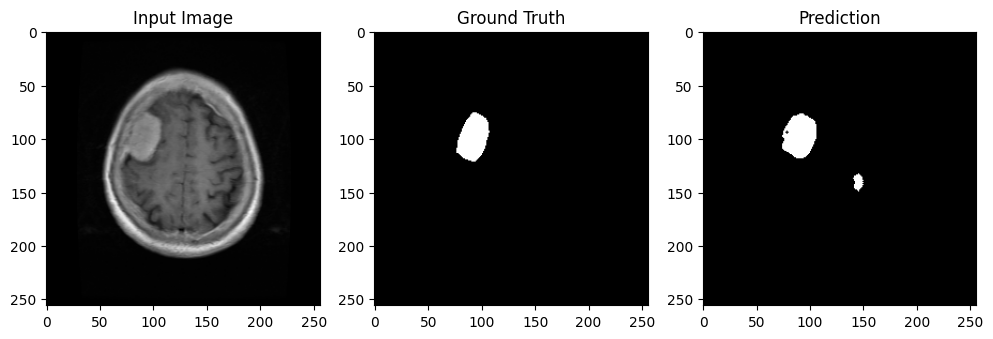

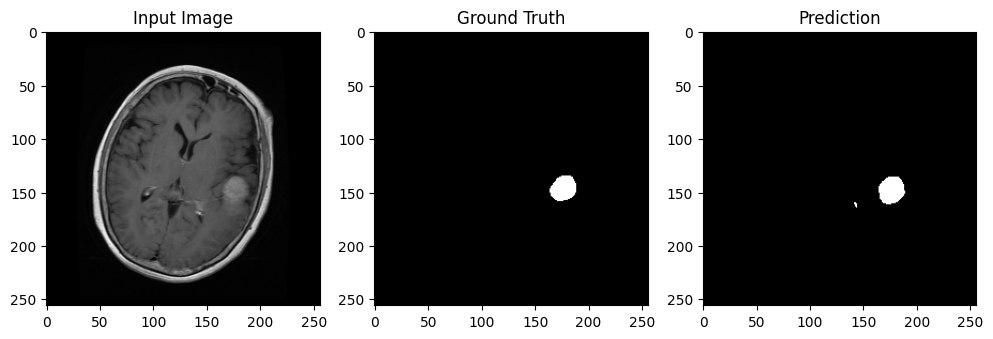

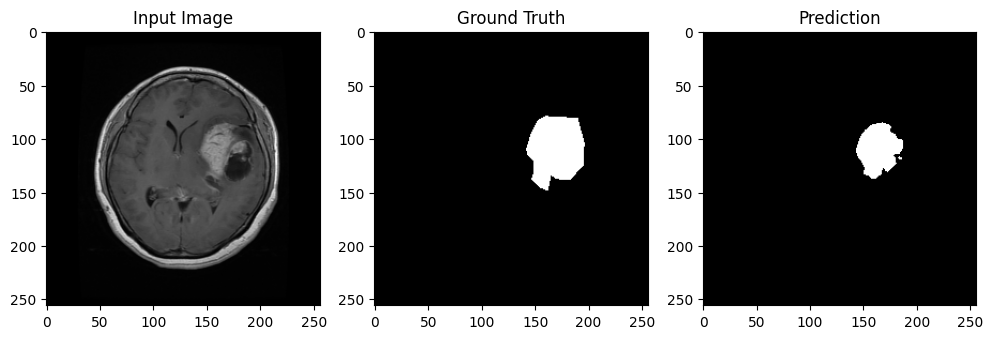

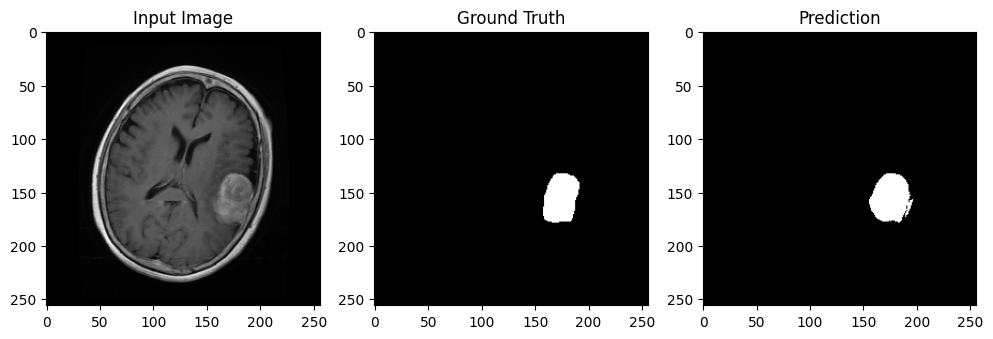

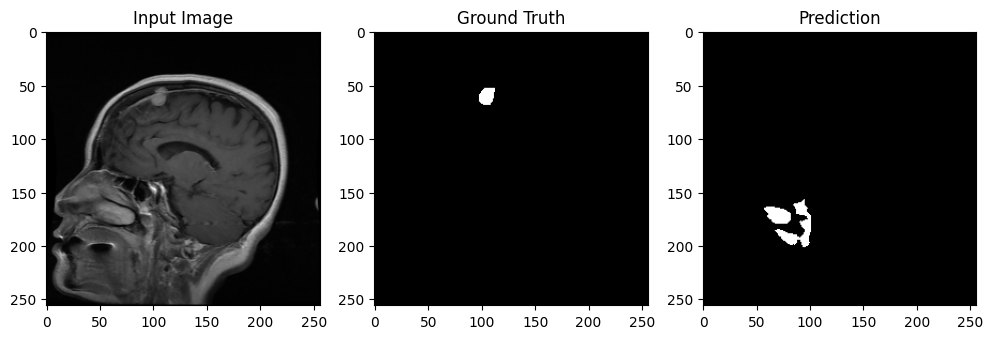

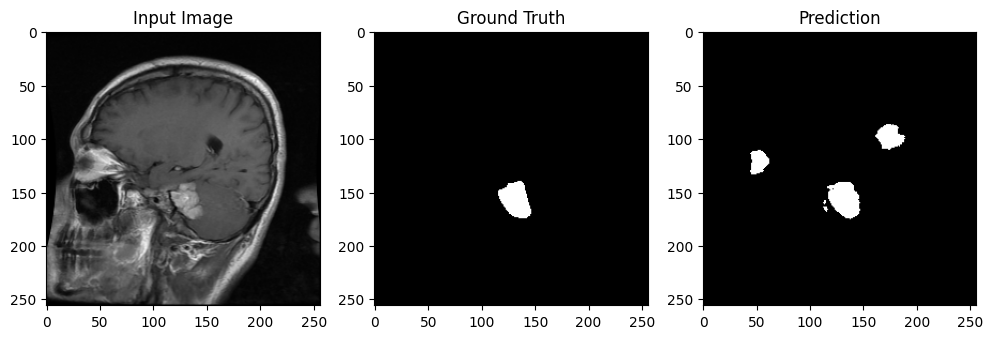

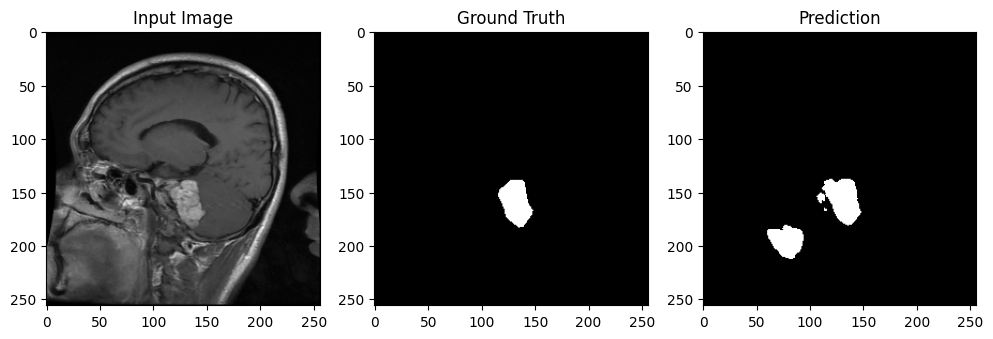

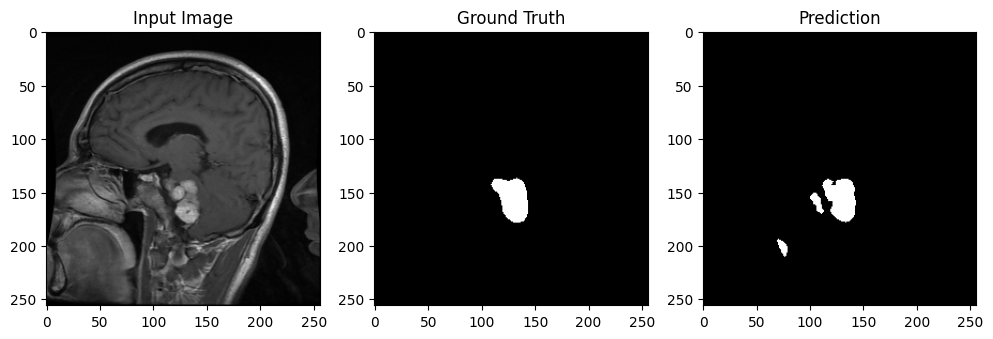

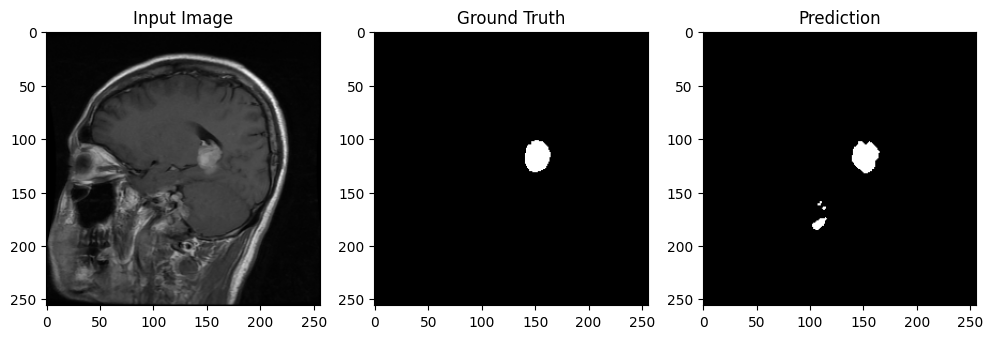

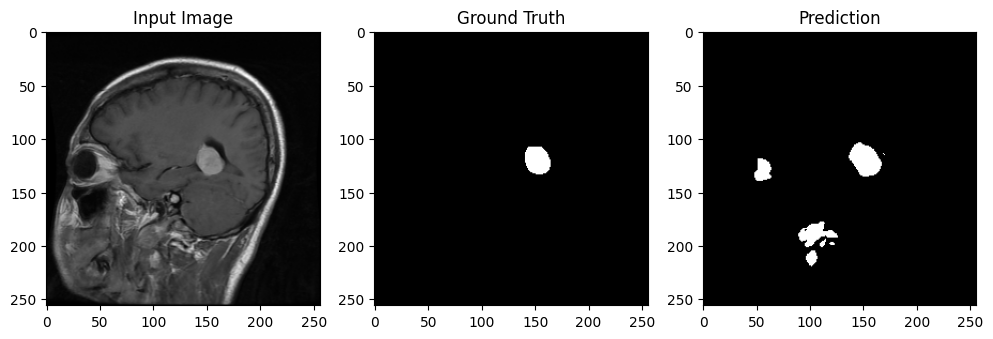

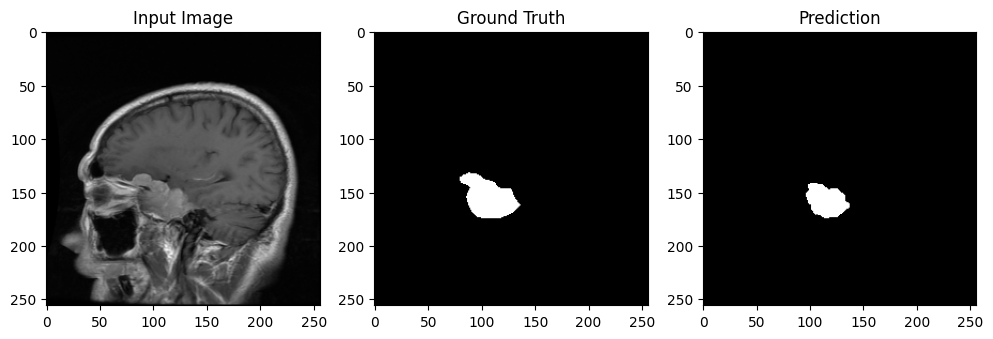

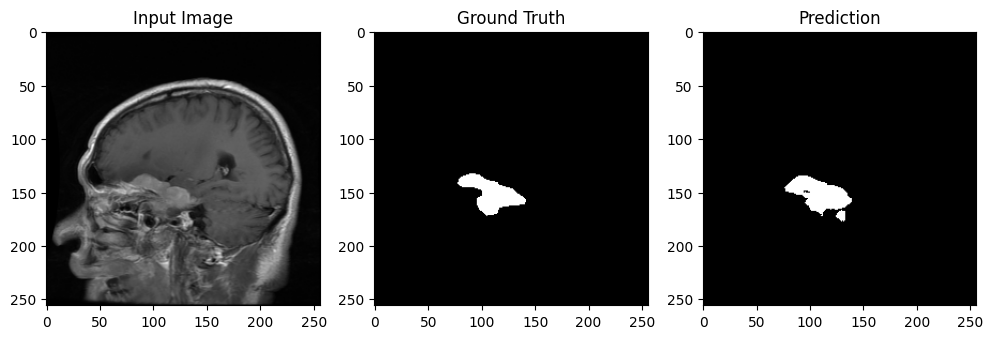

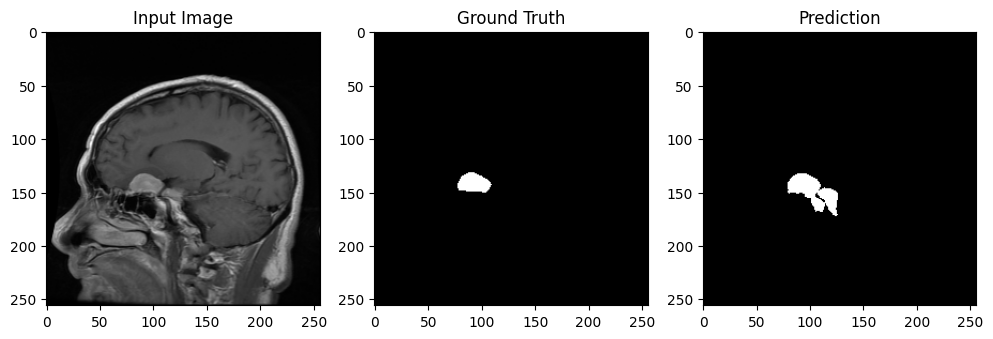

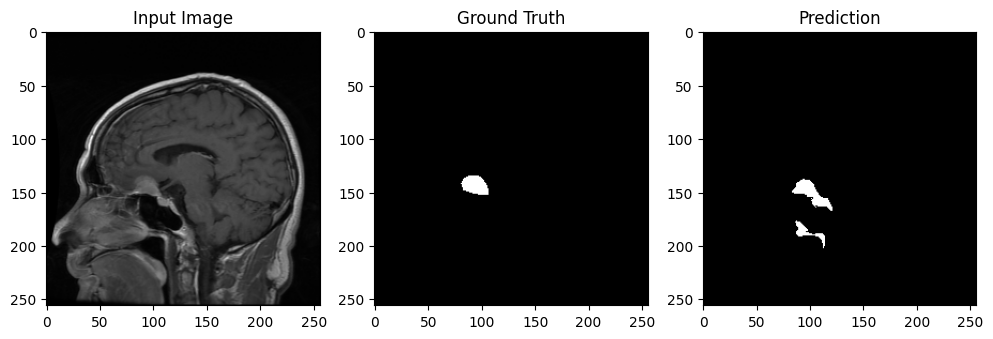

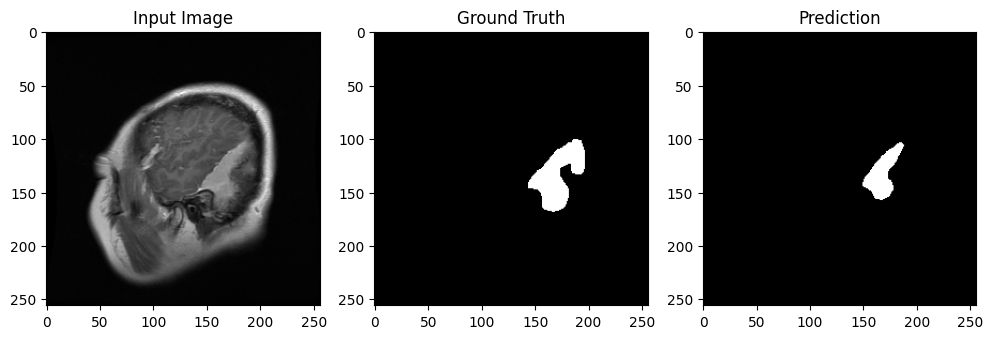

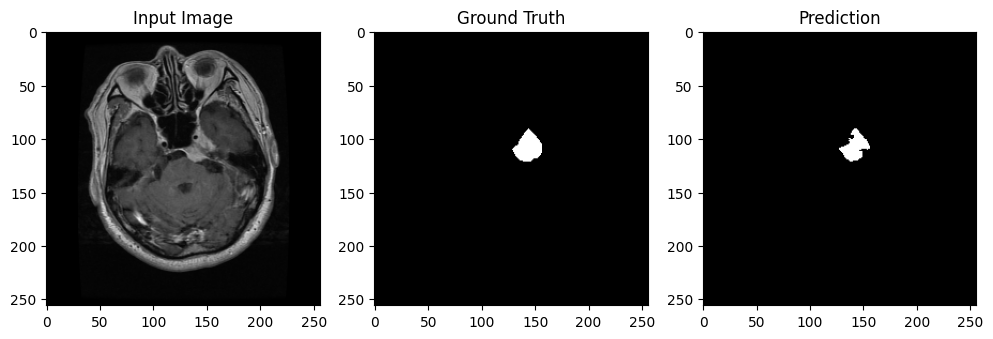

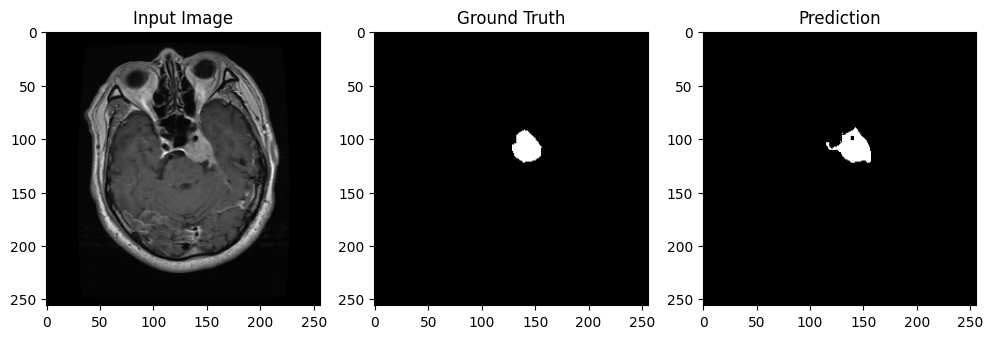

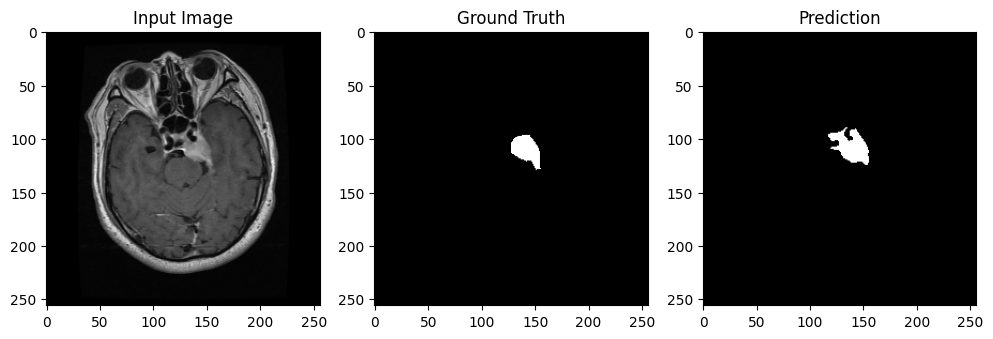

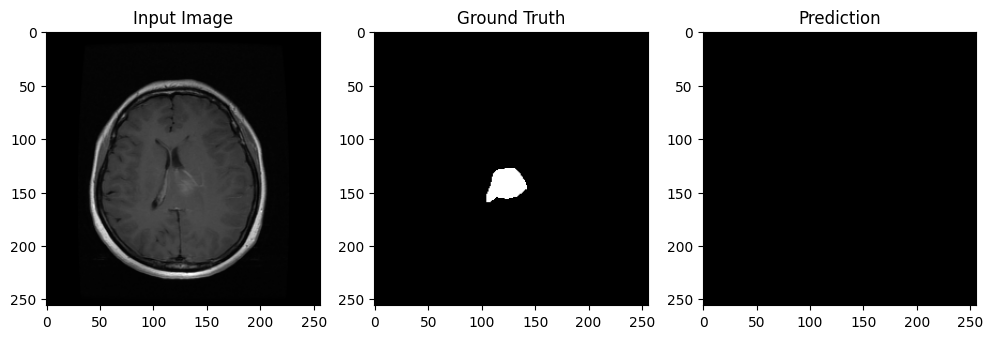

In [ ]:
if __name__ == "__main__":
    main()

In [ ]:
def inspect_checkpoint(checkpoint_path):
    try:
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        print(f"📁 Keys in checkpoint: {list(checkpoint.keys())}")
        print(f"📌 Saved at Epoch: {checkpoint.get('epoch', 'N/A')}")

        # Inspect model parameters
        model_state = checkpoint.get("state_dict", {})
        print(f"🧠 Total Parameters: {len(model_state)}")
        print("\n🔍 First 5 parameters:")
        for i, (key, value) in enumerate(model_state.items()):
            print(f"{i+1}. {key}: {tuple(value.shape)}")
            if i >= 4:
                break

        # Optional: Inspect optimizer state if needed
        if "optimizer" in checkpoint:
            print("\n🛠 Optimizer state found.")

    except Exception as e:
        print(f"❌ Error inspecting checkpoint: {e}")

# inspect_checkpoint("E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/models/unet/checkpoints/Collab/checkpoint_5_2025-03-26_05-42-36.pth.tar")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
summary(UNET(in_channel=1, out_channel=1).to(device), input_size=(1, 256, 256))